In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src"))

In [46]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose
from omegaconf import OmegaConf

import torch
import joblib
import pennylane as qml
import numpy as np
from pathlib import Path
from math import log2
from matplotlib import pyplot as plt

from models.neural_nets import FeedForwardNN
from utils.misc import add_mixed_states
from circuit import quantum_galton_board as qgb
from data.dist_sample import sample_expon
from models.model_run import dist_eval

In [41]:
# Get configuration's defaults
with initialize(version_base=None, config_path="../../src/config"):
    cfg = compose(config_name="config", overrides=["circuit.levels=5", "circuit.n_sims=100"])

In [3]:
def plot_histogram(dist_vals: np.ndarray, mixed_states: bool = False, plot_title: str = "") -> None:
    # Make a dictionary of the observations. Keys are the computational basis
    num_obs = len(dist_vals)
    num_qubits = int(log2(num_obs))

    if mixed_states:
        obs_dict = {format(idx, f"0{num_qubits}b"): value for idx, value in enumerate(dist_vals)}

    else:
        obs_dict = {format(2**idx, f"0{num_qubits}b"): dist_vals[2**idx] for idx in range(num_qubits)}

    x_pos = list(range(len(obs_dict)))

    # Plot the observations
    plt.bar(x_pos, list(obs_dict.values()), color="mediumseagreen")
    plt.xticks(x_pos, list(obs_dict.keys()), rotation=45)
    plt.xlabel("State")
    plt.ylabel("Probability")
    plt.title(plot_title)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# General algorithm fir the Galton Board

On our code, the number of levels correspond to the number of layers plus 1. A 1- and 2-layer board circuits with equal probability of the ball falling to each side can be run as follows:

(<Figure size 700x500 with 1 Axes>, <Axes: >)

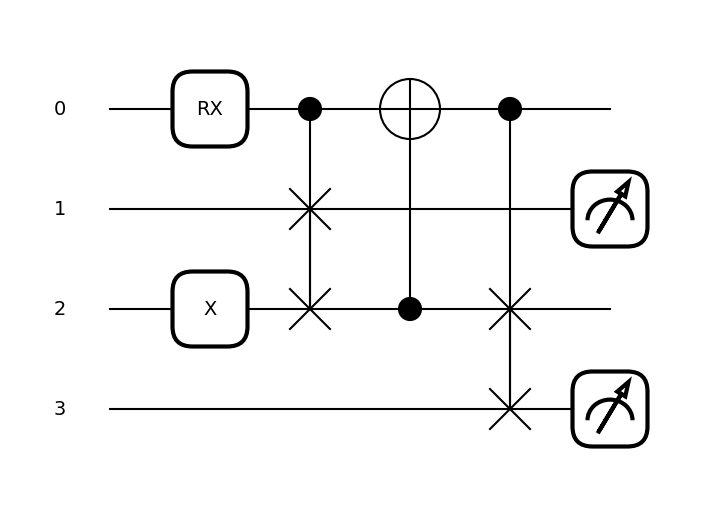

In [4]:
n = 2  # 1-layer board
qc_1 = qgb.build_galton_circuit(levels=n, num_shots=1000)
qml.draw_mpl(qc_1)()

(<Figure size 2300x700 with 1 Axes>, <Axes: >)

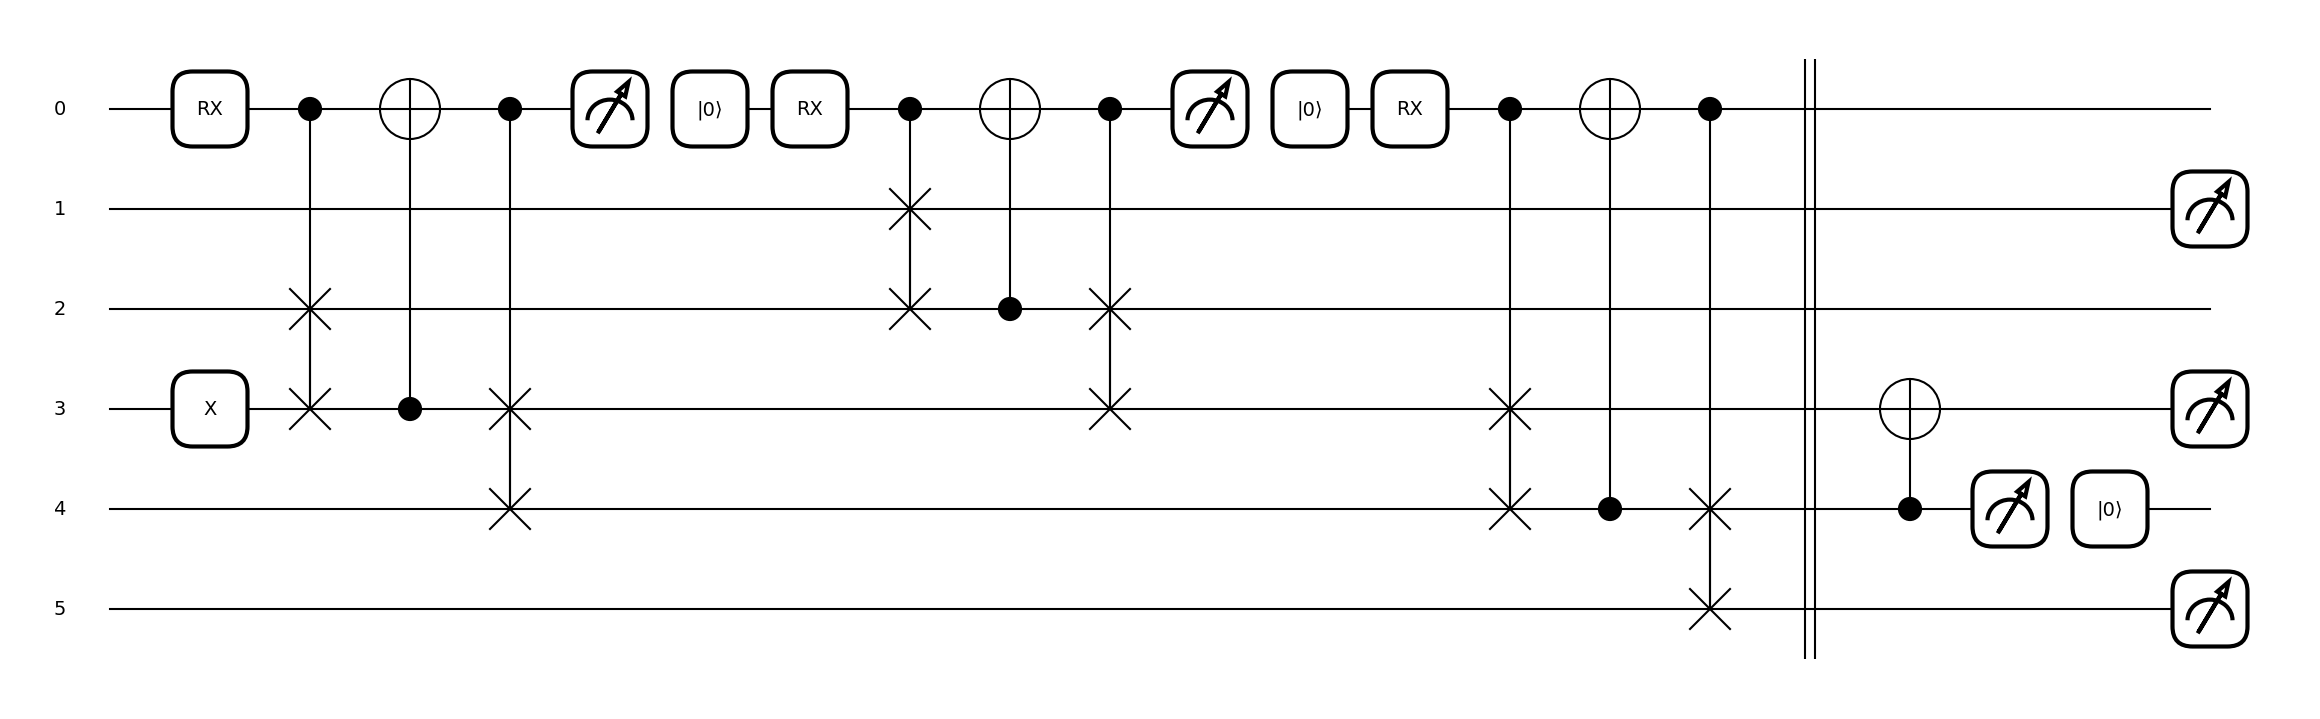

In [5]:
n = 3  # 2-layer board
qc_2 = qgb.build_galton_circuit(levels=n, num_shots=1000)
qml.draw_mpl(qc_2)()

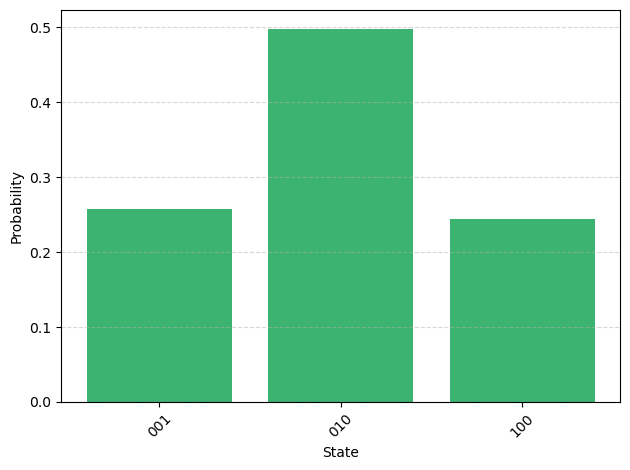

In [6]:
# Output is Gaussian
plot_histogram(qc_2())

# Obtain different distributions

## 5 levels QGB w/ Hadamard Walk

(<Figure size 4300x1100 with 1 Axes>, <Axes: >)

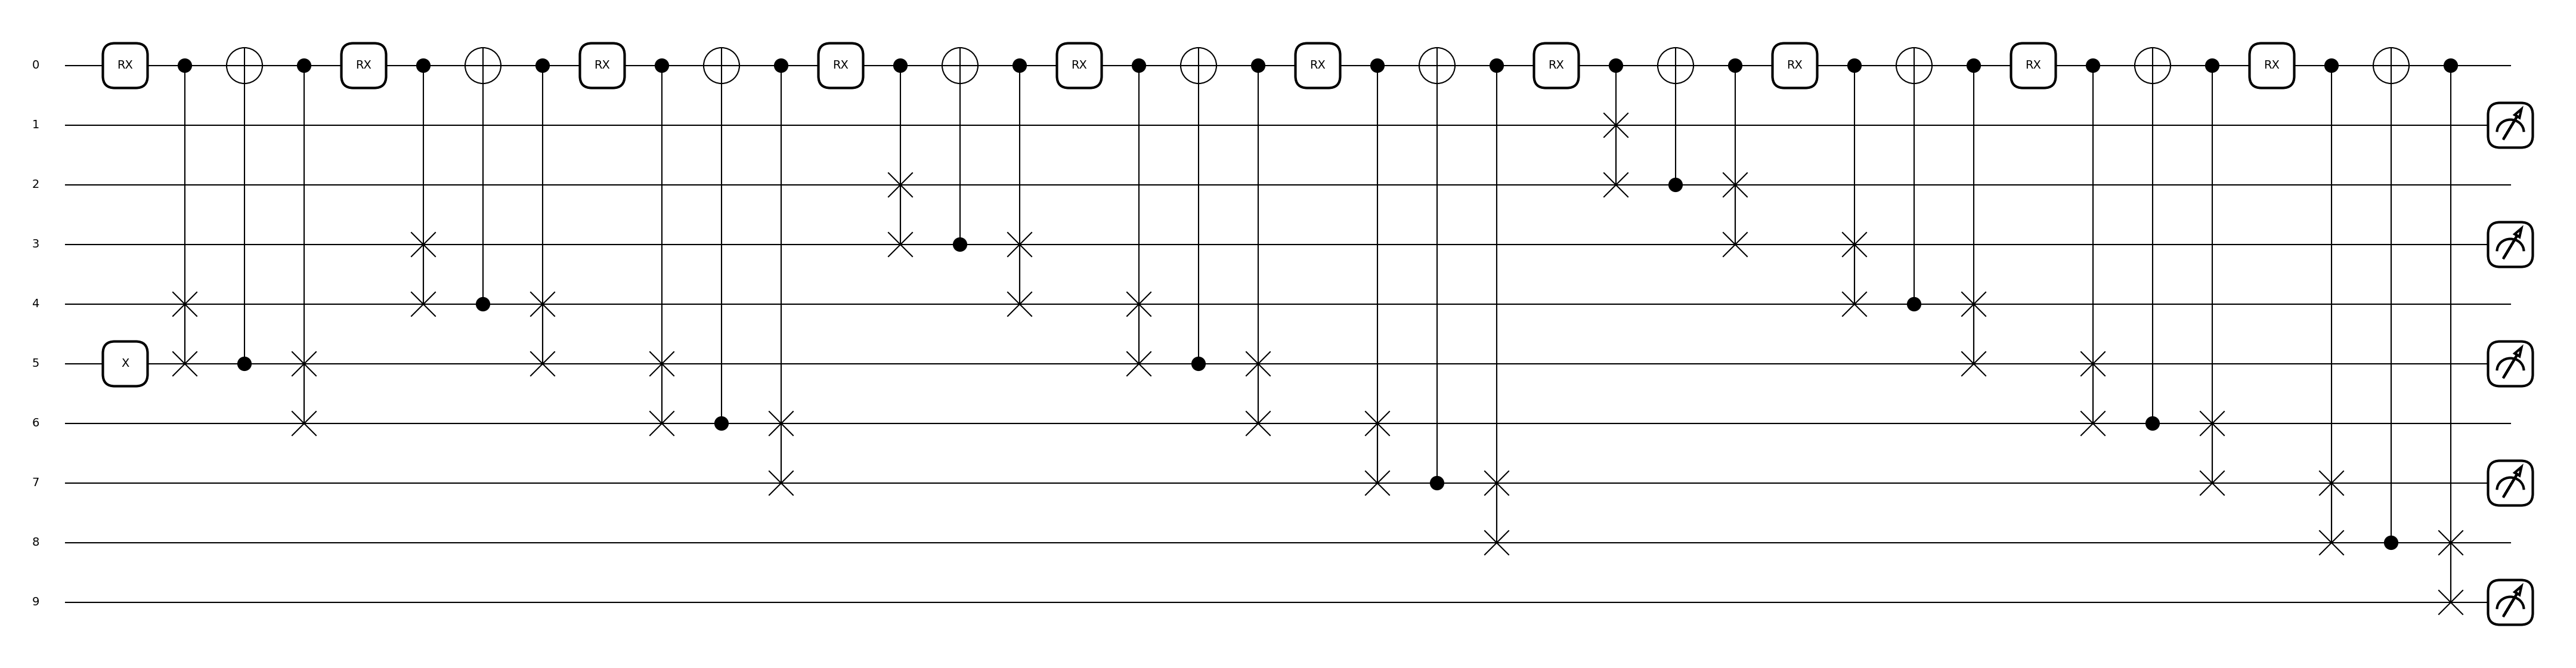

In [13]:
qc_h = qgb.build_galton_circuit(levels=5, num_shots=1000, coherence=True)
qml.draw_mpl(qc_h)()

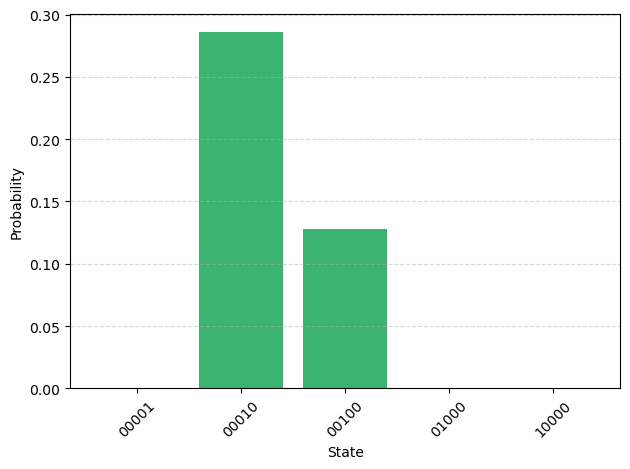

In [14]:
plot_histogram(qc_h())

## 5 levels QGB w/ exponential distribution

 Circuit's parameters can be obtained from a pre-trained neural network.

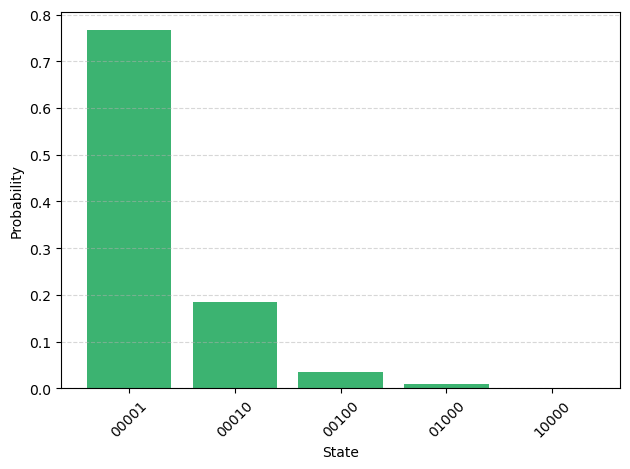

In [44]:
# Histogram of the target exponential distribution discretized to match the circuit's output
discrete_expon = add_mixed_states(sample_expon(lambda_val=1, n=1000, bins=5))
plot_histogram(discrete_expon)

(<Figure size 6900x1100 with 1 Axes>, <Axes: >)

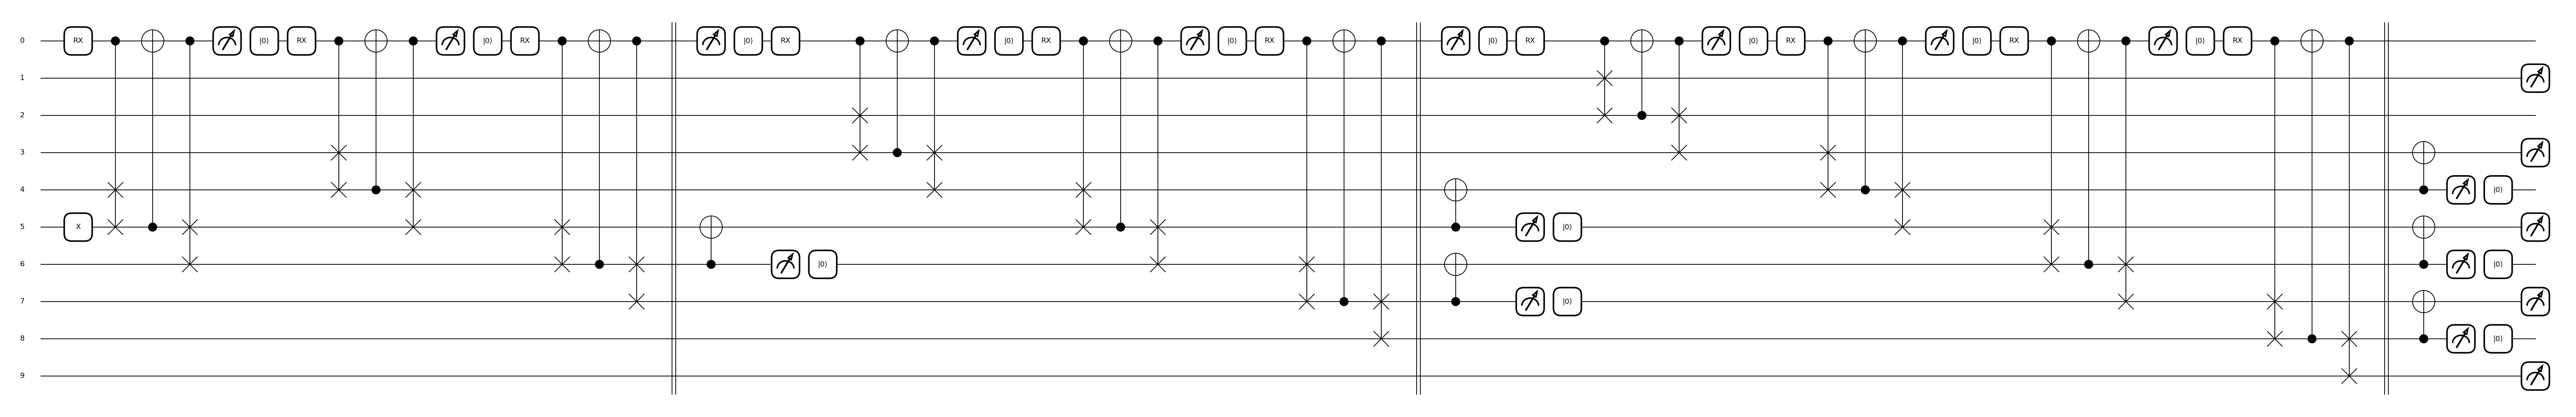

In [52]:
# Predict biases obtained from another run
pred_biases = [0.5957297086715698, 0.47815752029418945, 0.5320911407470703, 0.48657548427581787, 0.46620938181877136, 0.538258969783783, 0.5327324867248535, 0.5280758142471313, 0.545808732509613, 0.48983320593833923]

# Run the circuit with predicted parameters
qc_expon = qgb.build_galton_circuit(levels=5, num_shots=1000, bias=pred_biases)
qml.draw_mpl(qc_expon)()

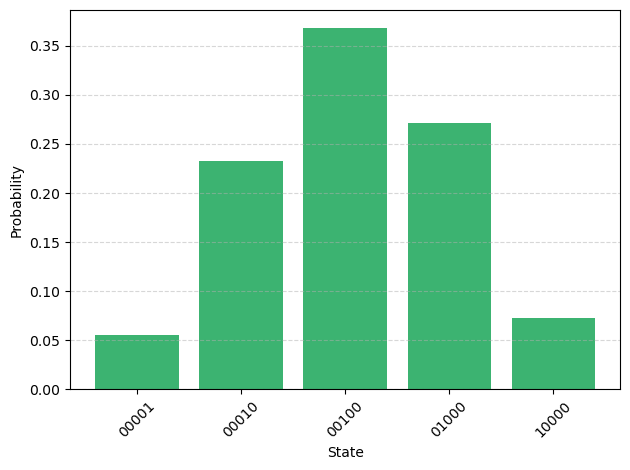

In [53]:
plot_histogram(qc_expon())